In [1]:
import pandas as pd
import sys

from transformers import AutoTokenizer
from datasets import load_dataset

sys.path.append('../')

from src.preprocessing import DataPreprocessor, FEATURES, PAD_FEATURE_VEC, BOUNDARY_FEATURE_VEC, UNK_FEATURE_VEC, MISMATCH_MAP, create_phoneme_map
from src.config import DataPreprocessingParams, TransformerSegmentationConfig, DatasetParams

In [2]:
phoible = pd.read_csv('../data/phoible.csv', sep=',', encoding='utf-8')

/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_4416/1109117776.py:1: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv('../data/phoible.csv', sep=',', encoding='utf-8')


In [3]:
tokenizer = AutoTokenizer.from_pretrained('transformersegmentation/CHILDES-Tokenizer')

In [4]:
dataset_params = DatasetParams(subconfig='english', name='transformersegmentation/CHILDES')
data_processing_params = DataPreprocessingParams(max_input_length=64, join_utts=False, map_phones_to_features=True)

In [5]:
phoneme_map = create_phoneme_map(tokenizer, 'english', '../data/phoible.csv')

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/CharTransformers/TransformerSegmentation/notebooks


/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/CharTransformers/TransformerSegmentation/notebooks/../src/preprocessing.py:35: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv(phoible_data_path)


In [8]:

dataset = load_dataset(dataset_params.name, dataset_params.subconfig, split='train')
data_preprocessor = DataPreprocessor(data_processing_params, tokenizer)
dataset = dataset.map(data_preprocessor, batched=True, remove_columns=['text'])
dataset

Found cached dataset childes (/Users/zebulongoriely/.cache/huggingface/datasets/transformersegmentation___childes/english/1.0.0/c1a2022b0fe6c73568543b5d30ee329425ac03b8b9f3d320d1fcc49917af66f1)
Loading cached processed dataset at /Users/zebulongoriely/.cache/huggingface/datasets/transformersegmentation___childes/english/1.0.0/c1a2022b0fe6c73568543b5d30ee329425ac03b8b9f3d320d1fcc49917af66f1/cache-57b816f575105797.arrow


Dataset({
    features: ['input_ids', 'attention_mask', 'word_starts'],
    num_rows: 350664
})

In [9]:
num_phonemes = 0
num_converted_phonemes = 0
phoneme_count = {}
for i in range(dataset.num_rows):
    utt = dataset[i]['input_ids']
    for j, phoneme in enumerate(utt):
        if phoneme < 6:
            continue
        num_phonemes += 1
        if phoneme not in phoneme_count:
            phoneme_count[phoneme] = 1
        else:
            phoneme_count[phoneme] += 1
        if phoneme_map[phoneme][-1] != 2:
            num_converted_phonemes += 1

print(f'Number of phonemes: {num_phonemes}')
print(f'Number of converted phonemes: {num_converted_phonemes}')
print(f'Percentage of converted phonemes: {num_converted_phonemes / num_phonemes * 100}%')

Number of phonemes: 3974747
Number of converted phonemes: 3939729
Percentage of converted phonemes: 99.11898795067962%


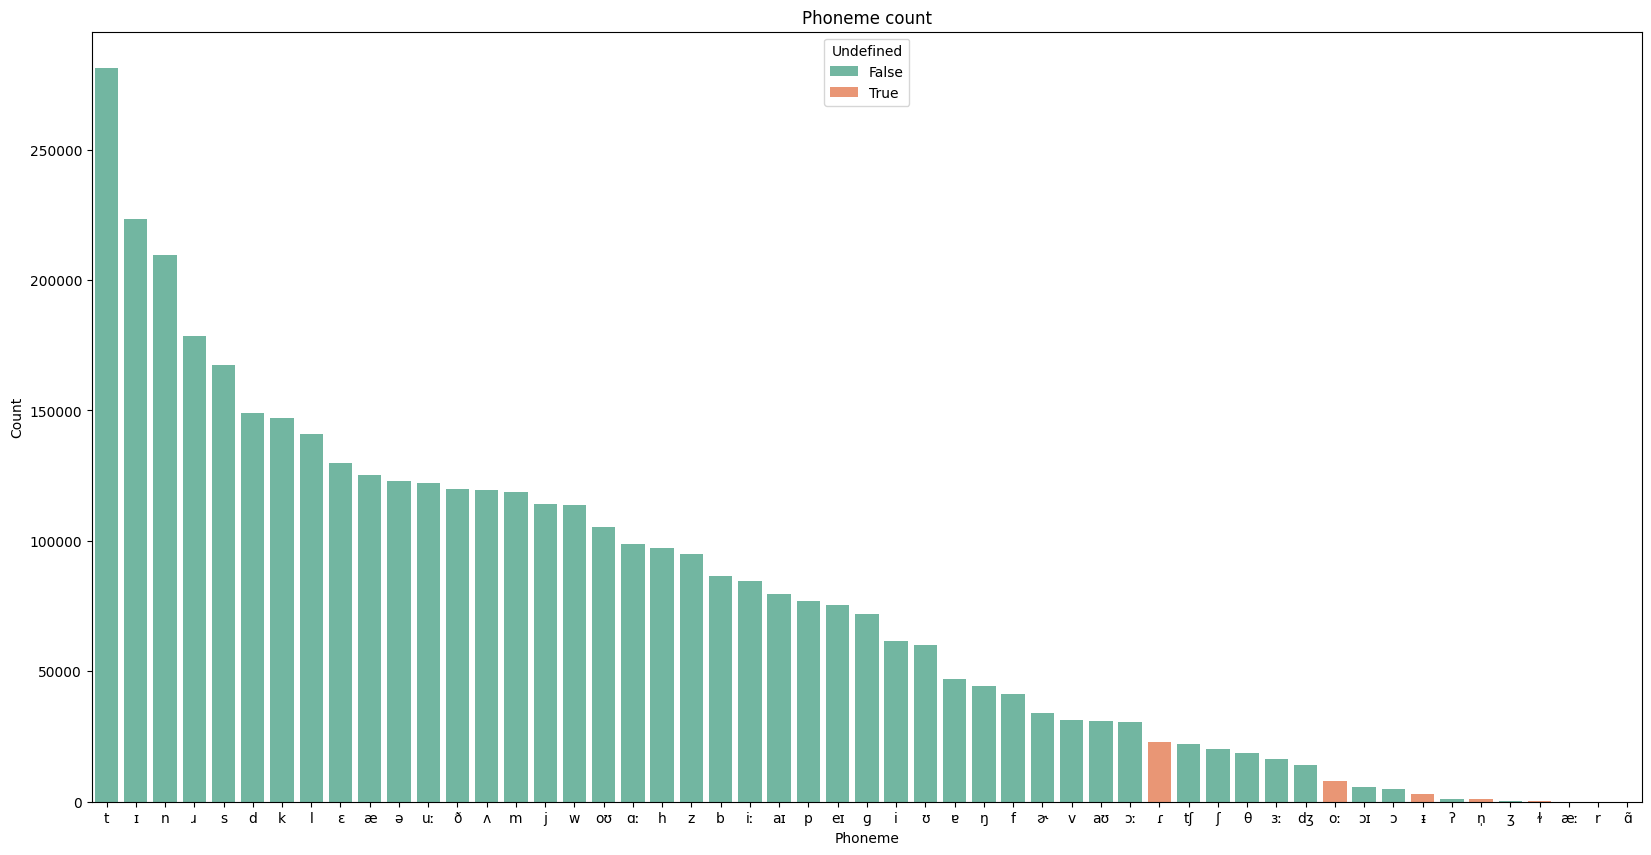

In [14]:
import matplotlib.pyplot as plt
import seaborn

plt.figure(figsize=(20, 10))
plt_data = pd.DataFrame(phoneme_count.items(), columns=['ID', 'Count'])
plt_data['Phoneme'] = plt_data['ID'].map(tokenizer.decode)
plt_data['Undefined'] = plt_data['ID'].map(lambda x: phoneme_map[x] in [PAD_FEATURE_VEC, BOUNDARY_FEATURE_VEC, UNK_FEATURE_VEC])
plt_data = plt_data.sort_values(by='Count', ascending=False)
seaborn.barplot(x='Phoneme', y='Count', data=plt_data, hue='Undefined', dodge=False, palette='Set2')

plt.xlabel('Phoneme')
plt.ylabel('Count')
plt.title('Phoneme count')

plt.show()


In [42]:
# Visualise feature vectors
import numpy as np
phoneme_ids = tokenizer.vocab.values()
phoneme_features = [phoneme_map[id] for id in phoneme_ids]
counts = [phoneme_count[id] if id in phoneme_count else 0 for id in phoneme_ids]
plt_data = pd.DataFrame({'ID' : phoneme_ids, 'Features' : phoneme_features, 'Phoneme' : tokenizer.vocab.keys(), 'Count' : counts})
plt_data = plt_data.sort_values(by='ID')

# Remove phonemes that have a count of less than 10
plt_data = plt_data[(plt_data['ID'] < 5) | (phoneme_count[plt_data['Count']] > 10)]
plt_data = plt_data.set_index('ID')

# Set features to individual columns
for i in range(len(FEATURES)):
    plt_data[FEATURES[i]] = plt_data['Features'].map(lambda x: x[i])
plt_data['BOUNDARY/PAD'] = plt_data['Features'].map(lambda x: x[-1])

# Plot heatmap of feature vectors
plt.figure(figsize=(20, 10))
# seaborn.heatmap(plt_data, cmap='binary', cbar=False, xticklabels=FEATURES + ['BOUND/UNK'], yticklabels=list(plt_data['Phoneme']))
seaborn.heatmap(plt_data.drop(columns=['Features', 'Phoneme']).T, yticklabels=FEATURES + ['BOUND/UNK'], xticklabels=plt_data['Phoneme'])
plt.xlabel('Feature')
plt.ylabel('Phoneme')
plt.title('Feature vectors')



TypeError: unhashable type: 'Series'

In [19]:
american_phonemes = phoible[phoible['LanguageName'] == 'American English'].Phoneme.unique()
british_phonemes = phoible[phoible['LanguageName'] == 'English'].Phoneme.unique()

print (len(american_phonemes), len(british_phonemes))
    

39 64


In [35]:
# Get phonemes undefined in phoneme map
undefined_phonemes = []
for phoneme, count in phoneme_count.items():
    if phoneme_map[phoneme] is None:
        undefined_phonemes.append(tokenizer.convert_ids_to_tokens(phoneme))
undefined_phonemes

['ᵻ', 'ɾ', 'oː', 'æː', 'n̩', 'ɑ̃', 'ɫ']